In [1]:
%pylab inline
rc("image", cmap="gray", interpolation="bicubic")
figsize(10, 10)
import helpers
import sys
if sys.version_info[0] == 3:
    from importlib import reload
reload(helpers)

Populating the interactive namespace from numpy and matplotlib


<module 'helpers' from '/mnt/Repositories/das2018-tutorial/helpers.py'>

# PyTorch

"Tensors and Dynamic neural networks in Python with strong GPU acceleration"

- like Matlab or Numpy, but with GPU support
- automatic, dynamic differentiation and gradient descent
- some frameworks for neural networks

# SIMPLE COMPUTATIONS

In [2]:
# simple "tensors" (multidimensional numerical arrays) in Torch

import torch
data = torch.rand(256, 256)
print (data)


 0.2518  0.0757  0.4360  ...   0.7512  0.8452  0.2152
 0.5223  0.9921  0.6378  ...   0.8359  0.3281  0.0751
 0.0067  0.7020  0.3593  ...   0.6900  0.3775  0.0152
          ...             ⋱             ...          
 0.1580  0.8200  0.5488  ...   0.5337  0.0299  0.5440
 0.2148  0.7201  0.1629  ...   0.8963  0.4770  0.9699
 0.1755  0.1437  0.4137  ...   0.4365  0.0518  0.7483
[torch.FloatTensor of size 256x256]



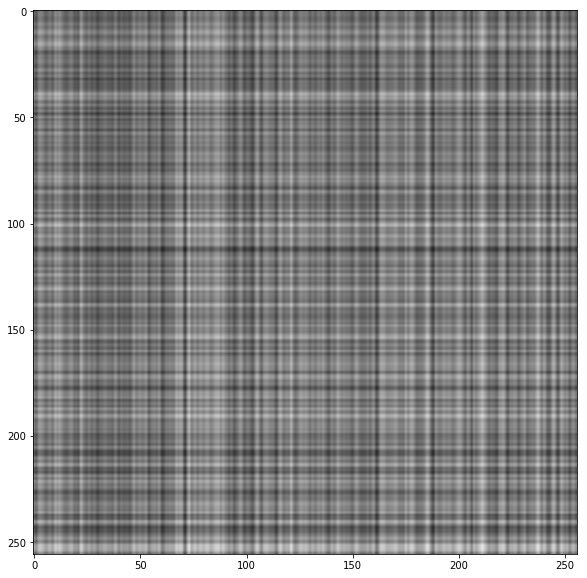

In [3]:
# a pointless GPU computation

data = torch.rand(256, 256).cuda()
out = data
for i in range(100):
    out = torch.mm(data, out)
    out /= out.norm()
imshow(out.cpu().numpy())

# PyTorch 

- standard set of numerical operations
- similar primitives to Numpy, Matlab
- operations run on CPU and GPU
- GPU operations use CUDA, cuDNN, some third party kernels
- direct binding: you call a numerical function, it calls the kernel

# AUTOMATIC DIFFERENTIATION

In [4]:
# Load the image and target
import scipy.ndimage as ndi
image = 1.0 * (rand(256, 256) > 0.99)
target = ndi.gaussian_filter(image, (5.0, 1.0))

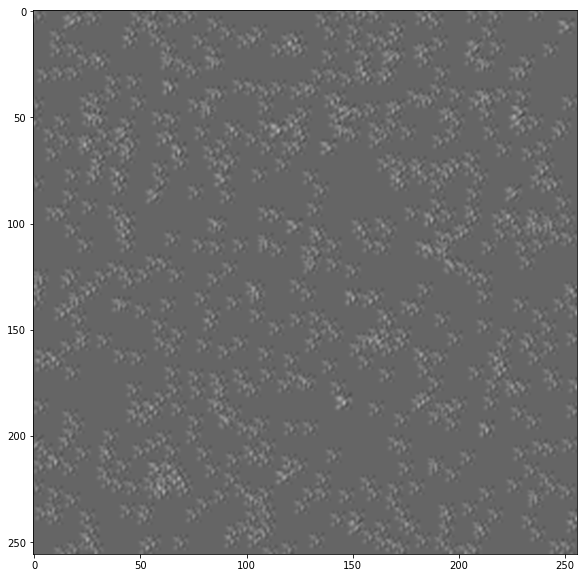

In [5]:
# 2D Convolution with Torch+GPU

import torch.nn.functional as F
from torch.autograd import Variable as Var

x = Var(torch.FloatTensor(image).cuda()[None, None, :, :], requires_grad=True)
y = Var(torch.FloatTensor(target).cuda()[None, None, :, :])

w = Var(torch.randn(1, 1, 7, 7).cuda(), requires_grad=True)

y_predicted = F.conv2d(x, w, padding=3)

imshow(y_predicted.data.cpu().numpy()[0, 0, :, :])

In [6]:
w

Variable containing:
(0 ,0 ,.,.) = 
 -0.6666  1.2092 -0.1337 -0.0657 -0.7548  0.9744  0.6026
  0.2514 -0.5489 -0.9868  0.9169 -0.4905  1.2190  0.3870
  0.0059 -0.1030 -0.1156  2.6718 -0.9663  0.1263 -0.3673
  1.0026 -1.3135  1.0822  1.1962  0.1405  0.2025  0.3919
  0.3321  1.3862 -1.1214  0.1483  0.7253  1.2333 -0.1002
  0.1469 -0.3475 -0.3288  0.2190  0.4983  1.0133  1.0651
 -0.9666 -0.0244  0.7526 -1.1883  0.5941 -1.0274 -0.0079
[torch.cuda.FloatTensor of size 1x1x7x7 (GPU 0)]

In [7]:
w.grad

In [8]:
# Computing the Error

err = ((y_predicted - y)**2).sum()
print (err)

err.backward(retain_graph=True)
print (w.grad)

Variable containing:
 22491.1836
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
(0 ,0 ,.,.) = 
  -773.4769  1647.1174   -70.6293   -36.7615  -916.8262  1356.9105   873.2444
   448.6550  -641.1816 -1231.1597  1260.7996  -512.4423  1650.5508   651.5110
    97.2659   -97.6852   -83.7867  3628.1960 -1170.3771   264.0845  -400.5282
  1386.6427 -1563.1534  1523.8623  1636.4038   227.1308   343.0141   634.6979
   544.1267  1906.7305 -1431.9314   248.3474  1024.6287  1749.9554   -54.5605
   276.9744  -408.8326  -382.8263   384.4194   751.9053  1442.6108  1433.9469
 -1154.7048    58.3964  1046.9363 -1463.4465   797.1719 -1120.8827    77.7381
[torch.cuda.FloatTensor of size 1x1x7x7 (GPU 0)]



{139797696624424: 'w', 139797696623944: 'x'}


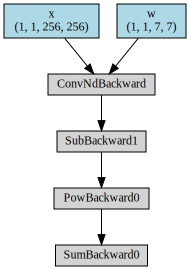

In [9]:
helpers.make_dot(err, dict(w=w, x=x))

# PyTorch Autograd Summary

- Tensors $\rightarrow$ Variables
- PyTorch keeps track of derivatives
- computation graphs can be completely dynamic
- propagate derivatives backwards using `x.backward()`
- access gradients using `x.grad`

# SIMPLE LEARNING

# Learning a Linear Filter

- a `Conv2d` layer is the same as a linear filter
- let's see whether we can learn this using PyTorch
- this uses all the components we need to train more complex models in PyTorch

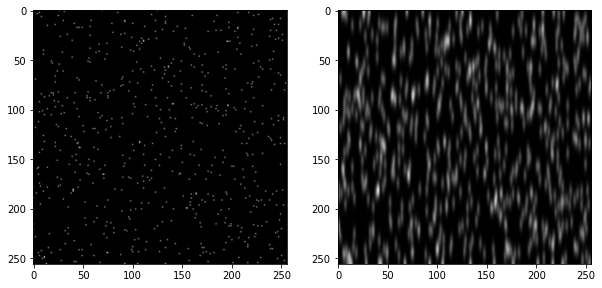

In [10]:
# "training data" is just a simple input/output pair
image = 1.0 * (rand(256, 256) > 0.99)
target = ndi.gaussian_filter(image, (5.0, 1.0))
subplot(121); imshow(image); subplot(122); imshow(target)

In [11]:
from torch import nn, optim

# the "model" is just a single convolutional layer
model = nn.Conv2d(1, 1, 17, padding=8)

# the loss is MSE loss
criterion = nn.MSELoss()

# put everything on the GPU
model.cuda()
criterion.cuda();

In [12]:
# train 10000 times

cuinput = Var(torch.FloatTensor(image).cuda())[None, None, :, :]
cutarget = Var(torch.FloatTensor(target).cuda())[None, None, :, :]

for i in range(10000):
    
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    optimizer.zero_grad()
    
    cuoutput = model(cuinput)
    
    loss = criterion(cuoutput, cutarget)
    loss.backward()
    
    optimizer.step()

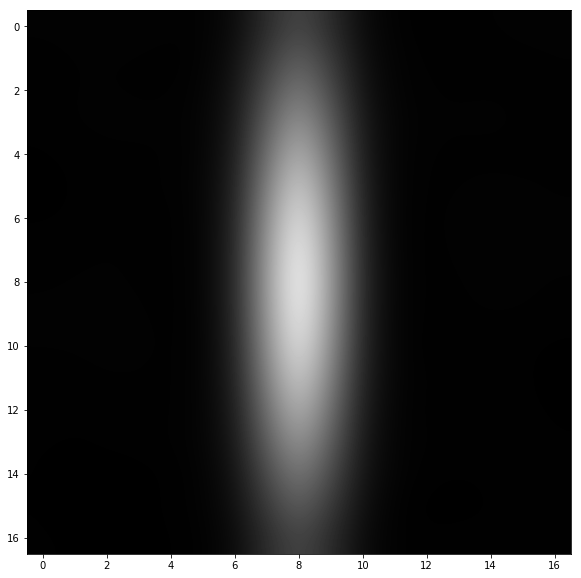

In [13]:
# display the learned kernel
imshow(list(model.parameters())[0].data[0,0].cpu().numpy())

# Torch "Modules" / "Layers"

In [14]:
import torch.functional as F

class Linear(nn.Module):
    def __init__(self, ninput, noutput):
        self.weights = Parameter(torch.randn(noutput, ninput))
    def forward(self, x):
        return F.linear(x, self.weights)
    # NB: no "backward" method needed

# Composition of Torch Layers

In [15]:
model = nn.Sequential(
    nn.Conv2d(1, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(1, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2, 2)  
)
model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (4): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
)

# Summary of Torch "Modules" and Training

- training uses modules, criteria, and optimizers
- modules (nn.Module) keep track of parameters and compute in the forward method
- criteria compute the differences between two outputs and return a scalar loss
- optimizers initiate gradient computation and then update the model parameters

# PYTORCH VS OTHERS

# Common Deep Learning Frameworks

Primary:

- TensorFlow
- PyTorch (old: Torch)
- Caffe 2 (old: Caffe)
- mxnet
- Chainer

Derived:

- Keras
- Theano

# TensorFlow

- superficially like PyTorch, but internally very different
- core is a dataflow language, completely separate from Python

Issues:
- tons of code between you and the kernels
- many custom written Google kernels
- memory hungry
- RNN support is worse

# PyTorch

Issues:

- Python multithreading is poor, therefore...
- limited ability to write high performance multi-GPU code

Potential Solutions:
- port to IronPython (C#, .NET)
- future, better Python JIT/compilers

# Future?

- both PyTorch and Tensorflow have serious limitations
- either they will substantially, or new frameworks will come around